# My financial journey


After a few years interested in the fianancial market, looking back I made a ton of mistakes and they made a better investor.

First of all, let me present myself. My name is Rafael, I am a undergraduate at University of São Paulo, studying Computer Information Systems. Working as a intern in a Asset Manegment Firm.

My journey in the financial market began with the 2018 bull market, it was the first time the Ibovespa hit 100k points and investing was becoming more accessible to the average Joe, with brokers like XP inc. offering the low fees to invest and user friendly experience to investing. Followed by this, the rise of fianancial influencer, like Thiago Nigro, also know as Primo Rico, explaning about the diverse products and how they could help the average person, not just the rich ones, to achive theirs financial goals.

You can cleary see this in the image bellow, with the vertical axis representing the amount of investors:

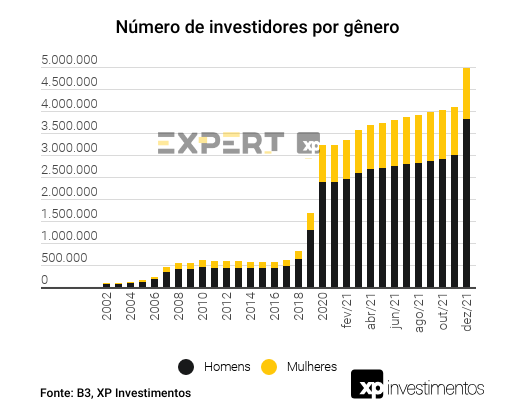

At home I also had a big influence in my dad, that always incentivise me and my brother to save money. His biggest incentive was the allowence he gave us, but it had a bonus, every end of the month it would compound 10%, giving us the idea of money in time.

During this time, I was in high school and a few friends of mine began to talk about making money in the market, also during that time the Youtube algorithm began to promote a lot of content related to finance. That made me research investing methods that would make the biggest amount of money in the least amount of time. 

With that goal in mind, i found technical analysis, with the two most prommissing tecniques been, moving averages and momentum investing. In this article i plan to discuss how these technics work and if they can produce results to the average person.

## Simple double moving averages investing

Moving averages trading is a technical analysis tool the involves two moving averages of a time-series, one long, signifing the longer term trend in the asset, and one short, signifing the short term trend. When the short term trend is above the long term one, the market is signaling a upward trend, so it's a buy signal. The oposite is true, when the long term trend is above the short term one, the market is in a downward trend.

The mathematical formula for the moving averages at a given time $t$:

$$
\begin{align}
a_{L, t} = \frac{1}{L}\sum^{L}_{j=1}p_{t - L + j} && a_{s, t} = \frac{1}{S}\sum^{S}_{j=1}p_{t - S + j}
\end{align}
$$

With $L$ being the long period, and $S$ being the short. To identify if the time $t$ is a buy, sell signal or neutral signal, we use the following ratio:

$$
R_t = \frac{a_{S, t} - a_{L, t}}{a_{L, t}}
$$

And the classification process, goes as following:
$$
Signal_t = 
\begin{aligned}
\begin{cases}
Buy: && R_t \gt B \\ 
Neutral: && -B \le R_t \le B \\
Sell: && R_t \lt -B
\end{cases}
\end{aligned}
$$

B is the bandwith of trading, if it's 0 every day you have a trading position.

Below a code that implements a simple moving average algorithm.

<Axes: xlabel='Date'>

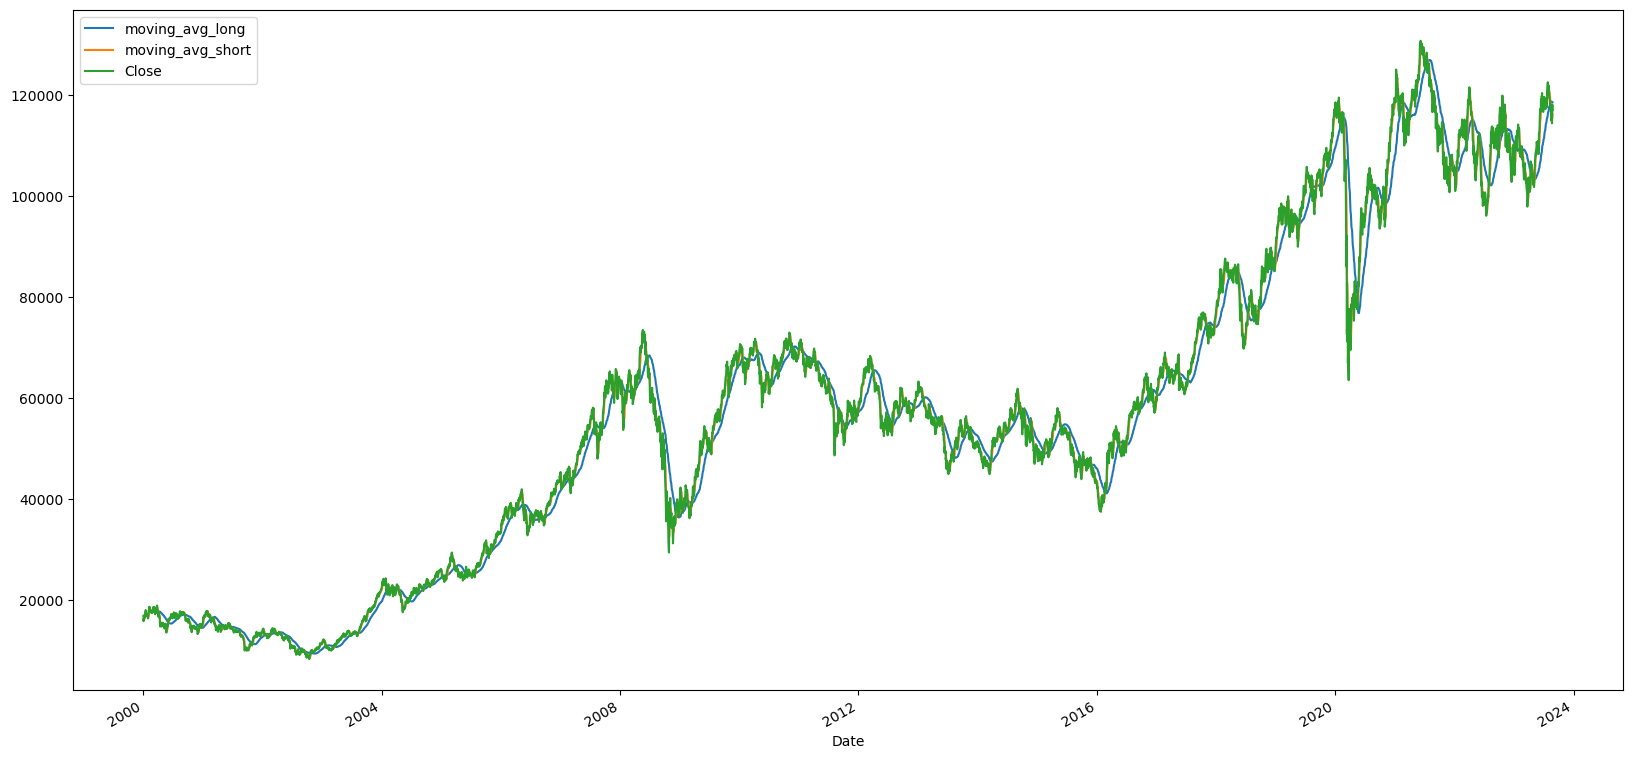

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from bcb import sgs

def moving_avg(time_serie: pd.Series, 
               period_long: int, 
               period_short: int,
               b: float = 0):
    df = time_serie.to_frame()
    df["moving_avg_long"] = time_serie.rolling(window=period_long).mean()
    df["moving_avg_short"] = time_serie.rolling(window=period_short).mean()
    df["ratio"] = (df["moving_avg_short"] - df["moving_avg_long"])/df["moving_avg_long"]
    def signal(x, b):
        if x > b:
            return 2
        elif x < -b:
            return 0
        else:
            return 1
    df["signal"] = df["ratio"].apply(signal, b=b)
    return df
web = yf.Ticker("^BVSP")
df_ibov = web.history(start=datetime.datetime(2000, 1, 1))["Close"]
df_ibov.index = pd.to_datetime(df_ibov.index).tz_localize(None)
selic = (sgs.get({"selic":432}, start = '2000-01-01')/100 + 1) ** (1/360)
series = moving_avg(df_ibov, 50, 5)
series[["moving_avg_long", "moving_avg_short", "Close"]].plot.line(figsize=(20, 10))

The algorithm is simple, using rolling windows to calculate the average for each time step and returning a dataframe with the averages and the classification for each period, with 2 being a buy signal, a 1 being a neutral position and a 0 a sell signal. Now that we have a working algorithm we can calculate if it generate profit or loss.

This function not only calculate the return, but also can account for taxes (we will see this later), and calculate the market return and the volatility of each estrategy.

In [49]:
def returns_moving_averages(df: pd.DataFrame,
                            risk_free_rate: pd.Series,
                            taxes = False) -> dict:
    df.dropna(inplace=True)
    return_buy = None
    return_sell = None
    last = None
    if taxes:
        tax = 0.8
    else:
        tax = 1
    risk_free_return = np.prod(risk_free_rate.values, dtype=np.float64)
    for ind, row in enumerate(df.to_dict("records")):
        if ind == 0:
            continue
        if row["signal"] == df.iloc[ind-1, -1]:
            if row["signal"] == 2:
                return_tmp = row["Close"]/df.iloc[ind-1, 0]
                if return_tmp > 1:
                    return_day = [[df.index[ind], return_tmp*tax]]
                else:
                    return_day = [[df.index[ind], return_tmp]]
                if return_buy is None:
                    return_buy = np.array(return_day)
                else:
                    return_buy = np.append(return_buy, return_day, axis=0)
            elif row["signal"] == 0:
                return_tmp = df.iloc[ind-1, 0]/row["Close"]
                if return_tmp > 1:
                    return_day = [[df.index[ind], return_tmp*tax]]
                else:
                    return_day = [[df.index[ind], return_tmp]]
                if return_sell is None:
                    return_sell = np.array(return_day)
                else:
                    return_sell = np.append(return_sell, return_day, axis=0)

    return_buy_signal = np.nanprod(return_buy[:, 1])
    return_sell_signal = np.nanprod(return_sell[:, 1])
    return_total = return_buy_signal*return_sell_signal
    asset_return = df["Close"][-1]/df["Close"][0]
    volatility_total = np.nanstd(np.append(return_buy[:, 1], return_sell[:, 1]), ddof=1)
    volatility_buy_signal = np.nanstd(return_buy[:, 1], ddof=1)
    volatility_sell_signal = np.nanstd(return_sell[:, 1], ddof=1)
    asset_volatility = np.nanstd(df["Close"].pct_change()+1)

    return {"return total": return_total,
            "volatility total": volatility_total,
            "return buy signal": return_buy_signal,
            "volatility buy signal": volatility_buy_signal,
            "return sell signal": return_sell_signal,
            "volatility sell signal": volatility_sell_signal,
            "asset returns": asset_return,
            "asset volatility": asset_volatility,
            "sharpe ratio": (return_total**(252/df.shape[0])-risk_free_return**(252/df.shape[0]))/(volatility_total*np.sqrt(252)),
            "return array buy signal": return_buy,
            "return array sell signal": return_sell,
            "return array": np.append(return_buy, return_sell, axis=0)}

In [50]:
results = returns_moving_averages(series, selic)
print(f"The returns of the buy and sell signals {round((results['return total'] - 1)*100, 2)}%")
print(f"The returns of the buy signals {round((results['return buy signal'] - 1)*100, 2)}%")
print(f"The returns of the sell signals {round((results['return sell signal'] - 1)*100, 2)}%")
print(f"The market return was {round((results['asset returns'] - 1)*100, 2)}%")
print(f"The sharpe ratio was {round(results['sharpe ratio'], 2)}%")

The returns of the buy and sell signals 4182.44%
The returns of the buy signals 1484.87%
The returns of the sell signals 170.21%
The market return was 573.26%
The sharpe ratio was 0.18%


As you can see we got really good, 8 times the results of the market. And that was what really caught my eyes in the beggining of the journey, it was almost magical, in 20 years you could multiply your money by 42 fold, while the market "only" gave almost 7 times. But maybe that was luck, lets try a wide range of parameters and windows of returns to see if this strategy still holds true. Let's make some hipotesys of what drives the returns:
- Volatility, the standard deviation of returns, the reason being the high amount of trades could benefit from the frequent changes in the prices
- Annualized returns, periods of high annualized returns could be amplified by the better timing due to trading, so the strategy will have generated alpha, while being beta-neutral
- During crisis, maybe it's a good indicator to when a big crash is commming
  
To test this thesis we are gonna to divide the ibovespa time-series according to a few criteria:
- The first one is according to volatility, the first period being from 2000 to 2008, the second from 2008 to 2012, the third from 2012 to 2020 and from 2020 to 2023
- The annualized returns from 2004 and 2008, 2016 to 2020
- The crisis from, 2008 to 2010 and 2019 to 2022
- And 3 ten year windows, from 2000 to 2010, from 2005 to 2015 and from 2013 to 2023

In the graph below you can see each of the periods:

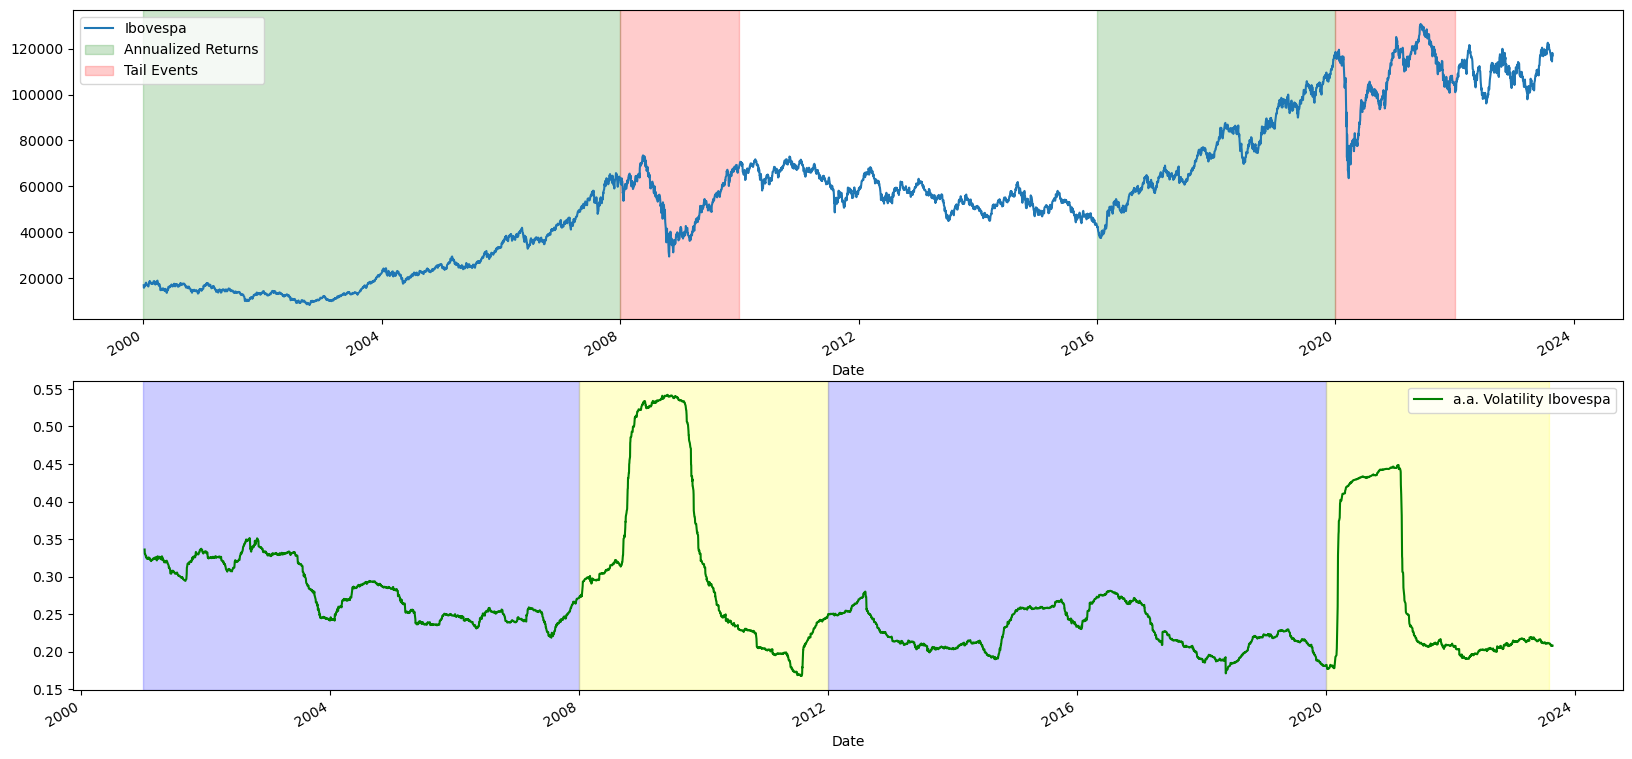

In [51]:
fig, ax = plt.subplots(nrows = 2, figsize=(20, 10))
df_ibov.plot(ax=ax[0], label="Ibovespa")
(df_ibov.pct_change().rolling(window=252).std()*np.sqrt(252)).plot(ax=ax[1], label="a.a. Volatility Ibovespa", color="green")

ax[0].axvspan(xmin="2000", xmax="2008", color="green", alpha=0.2, label="Annualized Returns")
ax[0].axvspan(xmin="2016", xmax="2020", color="green", alpha=0.2)
ax[0].axvspan(xmin="2008", xmax="2010", color="red", alpha=0.2, label="Tail Events")
ax[0].axvspan(xmin="2020", xmax="2022", color="red", alpha=0.2)

ax[1].axvspan(xmin="2001", xmax="2008", color="blue", alpha=0.2)
ax[1].axvspan(xmin="2008", xmax="2012", color="yellow", alpha=0.2)
ax[1].axvspan(xmin="2012", xmax="2020", color="blue", alpha=0.2)
ax[1].axvspan(xmin="2020", xmax="2023-08", color="yellow", alpha=0.2)

ax[0].legend(loc='upper left')
ax[1].legend(loc='best')
plt.show()

These periods will do the job for a simple article, but if you have any suggentions fell free to send in the comments.

Now that we have the periods lets test the strategy using different parameters for each period:

In [52]:
def backtest(time_series, risk_free, windows, long_window = (50, 100, 5), short_window = (1, 10, 4), b_range=(0, 0.01, 2),taxes = False):
    """
    Recives a time series as input an compute the moving averages for combintions of periods. 
    Return a DataFrame with returns, volatility and market information. 
    The index describe the iteration with the structure (long window, short window, b, period)
    
    The parameters [long_window, short_window, b_range], follow the patern (start, stop, num).
    
    Parameter
    """
    data = pd.DataFrame([])
    for window in windows:
        fold = time_series.loc[window[0]:window[1]]
        risk_free_fold = risk_free.loc[window[0]:window[1]]
        for long in np.linspace(start=long_window[0], stop=long_window[1], num=long_window[2], dtype=int):
            for short in np.linspace(start=short_window[0], stop=short_window[1], num=short_window[2], dtype=int):
                for b in np.linspace(start=b_range[0], stop=b_range[1], num=b_range[2], dtype=float):
                    results = returns_moving_averages(moving_avg(fold, long, short, b), risk_free_fold, taxes)
                    data = pd.concat([data, pd.DataFrame([(results['return total']**(252/fold.shape[0]) - 1)*100,
                                                          (results["asset returns"]**(252/fold.shape[0]) - 1)*100, 
                                                          (results['return buy signal']**(252/fold.shape[0]) - 1)*100, 
                                                          (results['return sell signal']**(252/fold.shape[0]) - 1)*100,
                                                          (results['volatility total']*100*np.sqrt(252)),
                                                          (results['volatility buy signal']*100*np.sqrt(252)), 
                                                          (results['volatility sell signal']*100*np.sqrt(252)),
                                                          (results['asset volatility']*100*np.sqrt(252)),
                                                          (results['sharpe ratio']),
                                                          (str(window)),
                                                          (f"({long}, {short}, {b})")],  # add Sharpe
                                                         index=["Annualized Returns Total", 
                                                                "Annualized Asset Return", 
                                                                "Annualized Returns Buy Signal", 
                                                                "Annualized Returns Sell Signal", 
                                                                "Annualized Volatility Total", 
                                                                "Annualized Volatility Buy", 
                                                                "Annualized Volatility Sell",
                                                                "Asset Annualized Volatility",
                                                                "Sharpe Ratio",
                                                                "Window",
                                                                "Parameters"], 
                                                         columns=[f"{long}, {short}, {b}"]).T], axis=0) #Adicionar o periodo
    data = data.astype({"Annualized Returns Total" : np.float64, 
                        "Annualized Asset Return" : np.float64, 
                        "Annualized Returns Buy Signal" : np.float64, 
                        "Annualized Returns Sell Signal" : np.float64, 
                        "Annualized Volatility Total" : np.float64, 
                        "Annualized Volatility Buy" : np.float64, 
                        "Annualized Volatility Sell": np.float64,
                        "Asset Annualized Volatility" : np.float64,
                        "Sharpe Ratio" : np.float64})
    return data

In [53]:
periods = [["2000", "2008"],["2008", "2012"], ["2012", "2020"], ["2020", "2023"],
           ["2004", "2008"], ["2016", "2020"],
           ["2008", "2010"], ["2020", "2022"],
           ["2000", "2010"],["2005", "2015"],["2013", "2023"]]
backtest_results = backtest(df_ibov, selic, periods)
groups_backtest = backtest_results.groupby("Window")

In [54]:
backtest_results

,Annualized Returns Total,Annualized Asset Return,Annualized Returns Buy Signal,Annualized Returns Sell Signal,Annualized Volatility Total,Annualized Volatility Buy,Annualized Volatility Sell,Asset Annualized Volatility,Sharpe Ratio,Window,Parameters
"50, 1, 0.0",61.321549,9.094072,32.296205,21.939665,31.555060,24.233743,39.933483,32.252260,1.429010,"['2000', '2008']","(50, 1, 0.0)"
"50, 1, 0.01",62.152260,9.094072,31.004556,23.776047,31.875449,23.641022,41.369616,32.252260,1.441583,"['2000', '2008']","(50, 1, 0.01)"
"50, 4, 0.0",23.323216,9.094072,15.151383,7.096600,32.177508,25.179624,40.029594,32.252260,0.184407,"['2000', '2008']","(50, 4, 0.0)"
"50, 4, 0.01",15.851775,9.094072,9.683690,5.623521,32.954095,25.160483,42.069905,32.252260,-0.052688,"['2000', '2008']","(50, 4, 0.01)"
"50, 7, 0.0",16.082407,9.094072,11.747512,3.879187,32.326532,25.632578,40.020894,32.252260,-0.046392,"['2000', '2008']","(50, 7, 0.0)"
...,...,...,...,...,...,...,...,...,...,...,...
"100, 4, 0.01",7.560184,7.285059,7.010663,0.513519,25.670610,20.762058,32.602992,25.080517,-0.077998,"['2013', '2023']","(100, 4, 0.01)"
"100, 7, 0.0",6.270880,7.285059,6.766317,-0.464039,25.294372,20.748012,31.631497,25.080517,-0.132255,"['2013', '2023']","(100, 7, 0.0)"
"100, 7, 0.01",5.549446,7.285059,5.862766,-0.295968,25.594678,20.731022,32.380797,25.080517,-0.160054,"['2013', '2023']","(100, 7, 0.01)"
"100, 10, 0.0",3.878361,7.285059,5.990884,-1.993118,25.389638,20.833350,31.622874,25.080517,-0.229853,"['2013', '2023']","(100, 10, 0.0)"


## Exploratory analysis of the periods

Now that we have the reasults from the backtest we can explore to identify patterns and the best parameters across the data.

First we try to identify what is the window that best perfomed across all the periods. For that we will look at the best sharpe in each period, the minimum volatility of each period, and look at the 10th percentile, 50th percentile and the 80th percentile for each metric

In [55]:
def period_comparisson(groups):
    results = {}
    for group in groups:
        df = group[1]
        best_sharpe = df.loc[df["Sharpe Ratio"].idxmax()]
        best_sharpe_percentiles = np.percentile(df["Sharpe Ratio"], [10, 50, 80])
        min_vol = df.loc[df["Annualized Volatility Total"].idxmin()]
        min_vol_percentiles = np.percentile(df["Annualized Volatility Total"], [10, 50, 80])
        results[group[0]] = {"Max sharpe": best_sharpe["Sharpe Ratio"],
                             "Parameters - Max sharpe": best_sharpe["Parameters"],
                             "10th percentile - Max sharpe": best_sharpe_percentiles[0],
                             "50th percentile - Max sharpe": best_sharpe_percentiles[1],
                             "80th percentile - Max sharpe": best_sharpe_percentiles[2],
                             "Min Volatility": min_vol["Annualized Volatility Total"],
                             "Parameters - Min Vol": min_vol["Parameters"],
                             "10th percentile - Min Vol": min_vol_percentiles[0],
                             "50th percentile - Min Vol": min_vol_percentiles[1],
                             "80th percentile - Min Vol": min_vol_percentiles[2]}
    return pd.DataFrame.from_dict(results, orient="index")

In [56]:
period_comparisson(groups_backtest).style.background_gradient()

,Max sharpe,Parameters - Max sharpe,10th percentile - Max sharpe,50th percentile - Max sharpe,80th percentile - Max sharpe,Min Volatility,Parameters - Min Vol,10th percentile - Min Vol,50th percentile - Min Vol,80th percentile - Min Vol
"['2000', '2008']",1.441583,"(50, 1, 0.01)",0.007014,0.124289,0.748532,31.468131,"(62, 1, 0.0)",31.629090,32.187126,32.421047
"['2000', '2010']",1.436162,"(50, 1, 0.0)",-0.011309,0.126963,0.793833,30.281088,"(75, 1, 0.0)",30.556539,31.206230,31.410588
"['2004', '2008']",1.217715,"(50, 1, 0.0)",-0.027395,0.129980,0.762074,32.136059,"(50, 1, 0.0)",32.716025,33.101270,33.524805
"['2005', '2015']",1.359738,"(50, 1, 0.0)",-0.039838,0.111401,0.828441,27.295151,"(50, 1, 0.0)",27.717117,28.384129,28.655846
"['2008', '2010']",1.597263,"(50, 1, 0.0)",0.346056,0.541233,0.999724,36.542761,"(50, 1, 0.0)",37.196992,37.862469,38.402535
"['2008', '2012']",1.480114,"(50, 1, 0.0)",0.120022,0.311085,0.802887,31.612001,"(50, 1, 0.0)",32.126054,32.498781,33.119436
"['2012', '2020']",1.452939,"(50, 1, 0.0)",-0.150319,0.127273,0.694645,25.311640,"(75, 1, 0.0)",25.638327,26.283530,26.676912
"['2013', '2023']",1.385663,"(50, 1, 0.01)",-0.174349,0.104789,0.697803,24.345636,"(75, 1, 0.0)",24.634889,25.350301,25.673573
"['2016', '2020']",1.401890,"(50, 1, 0.0)",-0.103636,0.133456,0.831516,27.225305,"(75, 1, 0.0)",27.519906,28.247842,28.984649
"['2020', '2022']",1.281149,"(50, 1, 0.0)",-0.604873,0.131718,0.657078,20.670347,"(87, 1, 0.01)",21.092542,22.331201,23.812373


From this quick analysis we can begin to see some patterns, the short window in all the periods has been 1, or the trading price and in most periods it seems that the longer window benefited from being lower too, the most frequent result being 50. This might happen because of the timing of the market, due to its lower moving averages it can capture small trends, resulting in a big amount of trades

Another trend we can see is the period from 2008 - 2010 being the best in almost every metric, meaning that it benefited from the 2008 mortgage crisis, but not benefited from the 2020-2022 crisis so well, maybe we have to check for differences in those two periods. 

We can also see that the strategy generated better results in the period pre 2010. This could be a result in the change of cicle in the market post 2008 crisis. That maybe a point valid to dug a little bit deeper.

## Analysing the 50, 1 parameter

The results that this combination gives us is almost magical, it seems to work like magic in all of the periods. My main hipotesis is that is due to it been capable of detecting small trends and making consistent profitable trades. To investigate this lets see short windows of time, compare it to the market returns and plot how many trades and when they were made.

In [8]:
best_window = window_stats.sort_values("mean annualized return", axis=1).columns[-1]
backtest_results_best_window = backtest_results[backtest_results["Window"] == best_window]
results_best_params = pd.DataFrame({"Returns": backtest_results_best_window["Annualized Returns Total"],
                                    "Excess Returns": backtest_results_best_window["Annualized Returns Total"] - backtest_results_best_window["Annualized Asset Return"],
                                    "Volatility": backtest_results_best_window["Annualized Volatility Total"],
                                    "Asset volatility": backtest_results_best_window["Asset Annualized Volatility"],
                                    "Sharpe Ratio": backtest_results_best_window["Sharpe Ratio"]})
results_best_params.sort_values("Sharpe Ratio", ascending=False).iloc[[*range(5), *range(-5, 0)]]

,Returns,Excess Returns,Volatility,Asset volatility,Sharpe Ratio
"50, 1, 0.0, 2000-01-2023-08",50.010286,41.515415,27.173986,27.882828,717032.093489
"50, 1, 0.0, 2000-01-2007-11",56.572419,38.149495,27.682195,28.551795,1703.412140
"50, 1, 0.0, 2007-11-2015-10",49.709729,52.708910,28.341590,29.168425,1175.042513
"50, 1, 0.0, 2015-10-2023-08",42.251625,29.320967,25.163305,25.479833,866.709297
"50, 1, 0.0, 2000-01-2004-09",64.738352,58.644272,30.531291,31.014223,436.558800
"50, 1, 0.0, 2017-09-2020-09",49.565217,38.227232,32.139530,31.090523,103.499396
"50, 1, 0.0, 2002-12-2005-11",47.725127,0.808238,25.514510,26.077620,103.259705
"50, 1, 0.0, 2020-09-2023-08",33.635908,30.837244,19.313682,20.175843,93.071659
"50, 1, 0.0, 2008-11-2011-10",39.700593,26.480041,24.097531,25.088703,92.753369
"50, 1, 0.0, 2014-10-2017-09",36.719184,20.202760,21.946162,23.671095,86.764706


This results show the 5 best and worst periods, by the sharpe ratio, using the the best params. Let's see what happend in each os this periods and why they perfomed the way they performed. For this analysis let's analyse what happened in the three best and worst of the periods:
- From 2000 to August 2023, the IBOVESPA, Brazil's main stock market index, displayed a volatile trajectory. The period saw significant fluctuations, including the dot-com bubble burst around 2000, the 2008 global financial crisis, and domestic economic and political challenges. However, it also witnessed periods of growth driven by commodities booms and investor sentiment shifts. Despite the volatility, the IBOVESPA managed to achieve overall gains, reflective of Brazil's evolving economic landscape and its position within global markets. Going from 16.000 points to around 115.000
- During the period from January 2000 to November 2007, the IBOVESPA, Brazil's main stock market index, experienced notable fluctuations. It began with moderate performance, followed by a substantial upward trend driven by growing commodity demand and economic optimism. However, this was accompanied by increased volatility due to global events like the 9/11 attacks and concerns over emerging markets. The index reached record highs in May 2008, yet by November 2007, signs of instability began to emerge, hinting at the impending global financial crisis.
- From November 2007 to October 2015, the IBOVESPA, Brazil's primary stock market indicator, witnessed a turbulent journey. This period commenced with the global financial crisis, which significantly impacted the index, causing a sharp decline. Subsequently, the IBOVESPA embarked on a recovery path, fueled by factors like Brazil's robust commodity exports and a growing domestic market. However, this upward trajectory was interspersed with economic challenges, including sluggish growth, political uncertainty, and declining commodity prices. As a result, the index faced notable volatility, reflecting Brazil's efforts to navigate both domestic and global economic headwinds.
- From September 2020 to August 2023, the IBOVESPA, Brazil's major stock market index, displayed a resilient performance amid a complex backdrop. The period began with market recovery from the initial COVID-19 shock, aided by stimulus measures and rising commodity prices. Despite ongoing pandemic-related concerns, the index exhibited intermittent growth, supported by government interventions and global economic rebound. Nevertheless, challenges persisted, including political uncertainties and fluctuations in investor sentiment. The IBOVESPA's journey during this time showcased its ability to adapt to dynamic conditions while remaining influenced by both domestic factors and worldwide events.
- From November 2008 to November 2011, the IBOVESPA, Brazil's primary stock market index, navigated a transformative period. Beginning with the aftermath of the global financial crisis, the index faced a sharp decline, mirroring global market turmoil. However, it then embarked on a substantial recovery, fueled by Brazil's strong economic fundamentals, commodity demand, and government stimulus. Despite this resurgence, the index encountered bouts of volatility due to concerns about the European debt crisis and global economic uncertainties. Throughout this span, the IBOVESPA reflected Brazil's resilience in bouncing back from crisis and its vulnerability to external shocks.
- From November 2014 to September 2017, the IBOVESPA, Brazil's prominent stock market index, experienced a roller-coaster ride marked by substantial shifts. This period commenced with economic challenges and political turmoil, leading to a decline in the index. As the Brazilian economy grappled with recession, falling commodity prices, and corruption scandals, the IBOVESPA faced volatility and negative sentiment. However, by mid-2016, signs of recovery emerged, propelled by policy reforms and a global commodities rebound. Despite this upward momentum, uncertainties remained due to ongoing political instability and economic fragility, underscoring the index's sensitivity to domestic and international factors.

Let's make graphs to have a better graphical view of what is happening in each of these periods:

In [47]:
def graph_periods(asset, risk_free, long, short, b):
    serie = moving_avg(asset, long, short, b)
    res = returns_moving_averages(serie, risk_free)
    ax = pd.Series(res["return array"][:, 1], index=res["return array"][:, 0]).sort_index().cumprod().plot.line()
    ax = (asset.pct_change() + 1).cumprod().plot.line(ax=ax)
    return ax

<Axes: xlabel='Date'>

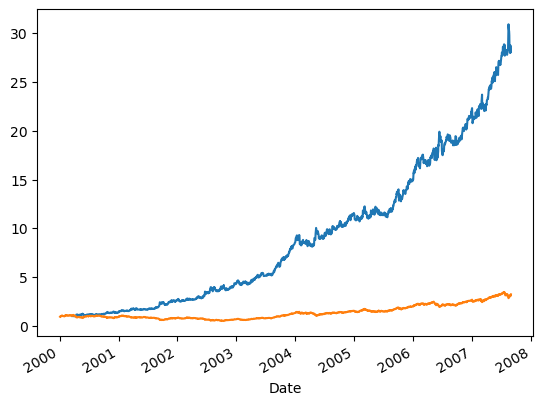

In [48]:
graph_periods(df_ibov.loc["2000-01":"2007-08"], selic.loc["2000-01":"2007-08"], 50, 1, .0)

In [ ]:
backtest_results[""]backtest_results.index.str[:6]

Everything always looks amazing, only in the worst case scenario you get results that are worst to the market. On average you are getting 3.5% more returns, per period and on the best cases you get 50% more returns. It seems like you beat the market and não it's just wait and retire early. But as my father always told me, "there is no free launch". At the time i didn't care about transaction costs and taxes and that was the catch. If a strategy so good and so easily distributed, the market is efficient enought to precify it, so it becomes not profitable in relation to the risk-free rate, this was demonstraded by XXX (Taylor).

In Brazil, whenever you trade above 20K R$ you have to pay 20% of your profits in taxes, only accounting for that we can change the previous formula to account for that. That really bad for our strategy due to high frquency of trading that is involved in the strategy. We can see the results below.

In [ ]:
backtest_tax_results = backtest(df, taxes=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
backtest_tax_results.sort_values("Annualized Returns Total", ascending=False).tail(10).plot.bar(ax=ax[1])
backtest_tax_results.sort_values("Annualized Returns Total", ascending=False).head(10).plot.bar(ax=ax[0], legend=False)

In [ ]:
backtest_tax_results.describe()

# Concluision

In this first part we saw how a simple double moving average works and understanding why it doesn't work in the real world. But that is not all that there is to it, trading rules like the one described in this article can e used to identify trend and imbalances in the the market due to the information you can get by the diference in the returns of buy and sell signals, identifying the distribution od these signal can give important data about the market. These strategies were also deeply used to prove or disprove the Efficient Market Hipotesysis, but thats a topic for a future episode in this series. 

If you want to dive deeper into this topic, I reccomend the book Asset price dynamics, volatility, and prediction by Stephen Taylor. This book was the base for this article and it dives into different markets and how trading rules can be used to get useful information.